# Value at Risk (VaR) Simulation

## Introduction

**Value at Risk (VaR)** is a statistical measure used in financial risk management to quantify the potential loss in value of a portfolio over a defined time horizon for a given confidence interval. It answers the question: *"What is the maximum loss that will not be exceeded with a certain probability over a given time period?"*

## Mathematical Framework

### Definition

For a portfolio with random return $R$ over time horizon $\Delta t$, the VaR at confidence level $\alpha$ (typically 95% or 99%) is defined as:

$$\text{VaR}_\alpha = -\inf\{x \in \mathbb{R} : F_R(x) > 1 - \alpha\}$$

where $F_R(x) = P(R \leq x)$ is the cumulative distribution function of returns.

Equivalently, VaR is the $(1-\alpha)$-quantile of the loss distribution:

$$P(L > \text{VaR}_\alpha) = 1 - \alpha$$

where $L = -R$ represents the loss.

### Parametric VaR (Variance-Covariance Method)

Under the assumption that returns follow a normal distribution $R \sim \mathcal{N}(\mu, \sigma^2)$:

$$\text{VaR}_\alpha = -(\mu + z_\alpha \sigma)$$

where $z_\alpha = \Phi^{-1}(1-\alpha)$ is the standard normal quantile, with $\Phi$ being the standard normal CDF.

For a portfolio value $V_0$:

$$\text{VaR}_\alpha^{\$} = V_0 \cdot \text{VaR}_\alpha$$

### Historical Simulation VaR

This non-parametric approach uses the empirical distribution of historical returns:

$$\text{VaR}_\alpha = -\text{Percentile}(\{r_1, r_2, \ldots, r_n\}, (1-\alpha) \times 100)$$

### Monte Carlo VaR

For complex portfolios, we simulate $N$ scenarios of future returns using:

$$r_i = \mu \Delta t + \sigma \sqrt{\Delta t} \cdot \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, 1)$$

The VaR is then estimated as the $(1-\alpha)$-quantile of the simulated loss distribution.

### Expected Shortfall (Conditional VaR)

A coherent risk measure that captures tail risk beyond VaR:

$$\text{ES}_\alpha = -\mathbb{E}[R | R \leq -\text{VaR}_\alpha] = \frac{1}{1-\alpha}\int_{-\infty}^{-\text{VaR}_\alpha} x \, dF_R(x)$$

For normal distributions:

$$\text{ES}_\alpha = \mu + \sigma \frac{\phi(z_\alpha)}{1-\alpha}$$

where $\phi$ is the standard normal PDF.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Generating Synthetic Portfolio Returns

We generate synthetic daily returns for a portfolio using a Geometric Brownian Motion (GBM) model, which is standard in quantitative finance. The log-returns follow:

$$r_t = \ln\left(\frac{S_t}{S_{t-1}}\right) \sim \mathcal{N}\left(\left(\mu - \frac{\sigma^2}{2}\right)\Delta t, \sigma^2 \Delta t\right)$$

In [2]:
# Portfolio parameters
portfolio_value = 1_000_000  # Initial portfolio value in USD
annual_return = 0.08         # Expected annual return (8%)
annual_volatility = 0.20     # Annual volatility (20%)

# Convert to daily parameters
trading_days = 252
daily_return = annual_return / trading_days
daily_volatility = annual_volatility / np.sqrt(trading_days)

# Generate 2 years of historical daily returns
n_historical_days = 504
historical_returns = np.random.normal(
    loc=daily_return - 0.5 * daily_volatility**2,
    scale=daily_volatility,
    size=n_historical_days
)

print(f"Portfolio Value: ${portfolio_value:,.0f}")
print(f"Daily Expected Return: {daily_return*100:.4f}%")
print(f"Daily Volatility: {daily_volatility*100:.4f}%")
print(f"Historical Sample Size: {n_historical_days} days")
print(f"\nHistorical Returns Statistics:")
print(f"  Mean: {np.mean(historical_returns)*100:.4f}%")
print(f"  Std Dev: {np.std(historical_returns)*100:.4f}%")
print(f"  Skewness: {stats.skew(historical_returns):.4f}")
print(f"  Kurtosis: {stats.kurtosis(historical_returns):.4f}")

Portfolio Value: $1,000,000
Daily Expected Return: 0.0317%
Daily Volatility: 1.2599%
Historical Sample Size: 504 days

Historical Returns Statistics:
  Mean: 0.0374%
  Std Dev: 1.2387%
  Skewness: 0.1752
  Kurtosis: 0.2272


## VaR Calculation Methods

We implement three standard approaches to calculate VaR:

1. **Parametric (Variance-Covariance)**: Assumes normal distribution
2. **Historical Simulation**: Uses empirical distribution
3. **Monte Carlo Simulation**: Generates future scenarios

In [3]:
def parametric_var(returns, confidence_level, portfolio_value):
    """
    Calculate Parametric VaR assuming normal distribution.
    
    Parameters:
    -----------
    returns : array-like
        Historical returns
    confidence_level : float
        Confidence level (e.g., 0.95 for 95%)
    portfolio_value : float
        Current portfolio value
        
    Returns:
    --------
    var_pct : float
        VaR as percentage
    var_dollar : float
        VaR in dollar terms
    """
    mu = np.mean(returns)
    sigma = np.std(returns)
    z_score = norm.ppf(1 - confidence_level)
    
    var_pct = -(mu + z_score * sigma)
    var_dollar = portfolio_value * var_pct
    
    return var_pct, var_dollar


def historical_var(returns, confidence_level, portfolio_value):
    """
    Calculate Historical Simulation VaR.
    
    Uses the empirical distribution of historical returns.
    """
    var_pct = -np.percentile(returns, (1 - confidence_level) * 100)
    var_dollar = portfolio_value * var_pct
    
    return var_pct, var_dollar


def monte_carlo_var(returns, confidence_level, portfolio_value, n_simulations=10000):
    """
    Calculate Monte Carlo VaR.
    
    Simulates future returns based on estimated parameters.
    """
    mu = np.mean(returns)
    sigma = np.std(returns)
    
    # Simulate future returns
    simulated_returns = np.random.normal(mu, sigma, n_simulations)
    
    var_pct = -np.percentile(simulated_returns, (1 - confidence_level) * 100)
    var_dollar = portfolio_value * var_pct
    
    return var_pct, var_dollar, simulated_returns


def expected_shortfall(returns, confidence_level, portfolio_value):
    """
    Calculate Expected Shortfall (Conditional VaR).
    
    Average loss beyond the VaR threshold.
    """
    var_pct = -np.percentile(returns, (1 - confidence_level) * 100)
    # ES is the mean of losses exceeding VaR
    es_pct = -np.mean(returns[returns <= -var_pct])
    es_dollar = portfolio_value * es_pct
    
    return es_pct, es_dollar

In [4]:
# Calculate VaR at different confidence levels
confidence_levels = [0.90, 0.95, 0.99]

results = []

print("=" * 80)
print("VALUE AT RISK ANALYSIS")
print("=" * 80)

for cl in confidence_levels:
    print(f"\n{'='*80}")
    print(f"Confidence Level: {cl*100:.0f}%")
    print("=" * 80)
    
    # Parametric VaR
    p_var_pct, p_var_dollar = parametric_var(historical_returns, cl, portfolio_value)
    print(f"\nParametric VaR:")
    print(f"  Percentage: {p_var_pct*100:.4f}%")
    print(f"  Dollar: ${p_var_dollar:,.2f}")
    
    # Historical VaR
    h_var_pct, h_var_dollar = historical_var(historical_returns, cl, portfolio_value)
    print(f"\nHistorical VaR:")
    print(f"  Percentage: {h_var_pct*100:.4f}%")
    print(f"  Dollar: ${h_var_dollar:,.2f}")
    
    # Monte Carlo VaR
    mc_var_pct, mc_var_dollar, sim_returns = monte_carlo_var(
        historical_returns, cl, portfolio_value, n_simulations=100000
    )
    print(f"\nMonte Carlo VaR (100,000 simulations):")
    print(f"  Percentage: {mc_var_pct*100:.4f}%")
    print(f"  Dollar: ${mc_var_dollar:,.2f}")
    
    # Expected Shortfall
    es_pct, es_dollar = expected_shortfall(historical_returns, cl, portfolio_value)
    print(f"\nExpected Shortfall (CVaR):")
    print(f"  Percentage: {es_pct*100:.4f}%")
    print(f"  Dollar: ${es_dollar:,.2f}")
    
    results.append({
        'Confidence': f"{cl*100:.0f}%",
        'Parametric VaR ($)': p_var_dollar,
        'Historical VaR ($)': h_var_dollar,
        'Monte Carlo VaR ($)': mc_var_dollar,
        'Expected Shortfall ($)': es_dollar
    })

VALUE AT RISK ANALYSIS

Confidence Level: 90%

Parametric VaR:
  Percentage: 1.5501%
  Dollar: $15,501.22

Historical VaR:
  Percentage: 1.5323%
  Dollar: $15,323.01

Monte Carlo VaR (100,000 simulations):
  Percentage: 1.5503%
  Dollar: $15,503.16

Expected Shortfall (CVaR):
  Percentage: 2.0394%
  Dollar: $20,393.71

Confidence Level: 95%

Parametric VaR:
  Percentage: 2.0002%
  Dollar: $20,001.50

Historical VaR:
  Percentage: 1.8851%
  Dollar: $18,850.87

Monte Carlo VaR (100,000 simulations):
  Percentage: 1.9946%
  Dollar: $19,946.34

Expected Shortfall (CVaR):
  Percentage: 2.3613%
  Dollar: $23,612.88

Confidence Level: 99%

Parametric VaR:
  Percentage: 2.8443%
  Dollar: $28,443.28

Historical VaR:
  Percentage: 2.5448%
  Dollar: $25,448.49

Monte Carlo VaR (100,000 simulations):
  Percentage: 2.8558%
  Dollar: $28,557.88

Expected Shortfall (CVaR):
  Percentage: 2.9985%
  Dollar: $29,985.42


In [5]:
# Create summary DataFrame
results_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(results_df.to_string(index=False))


SUMMARY TABLE
Confidence  Parametric VaR ($)  Historical VaR ($)  Monte Carlo VaR ($)  Expected Shortfall ($)
       90%        15501.221030        15323.014472         15503.160769            20393.709326
       95%        20001.500113        18850.868014         19946.336268            23612.875940
       99%        28443.275239        25448.489911         28557.881045            29985.421468


## Visualization

We create comprehensive visualizations to illustrate the VaR concepts and compare different methodologies.

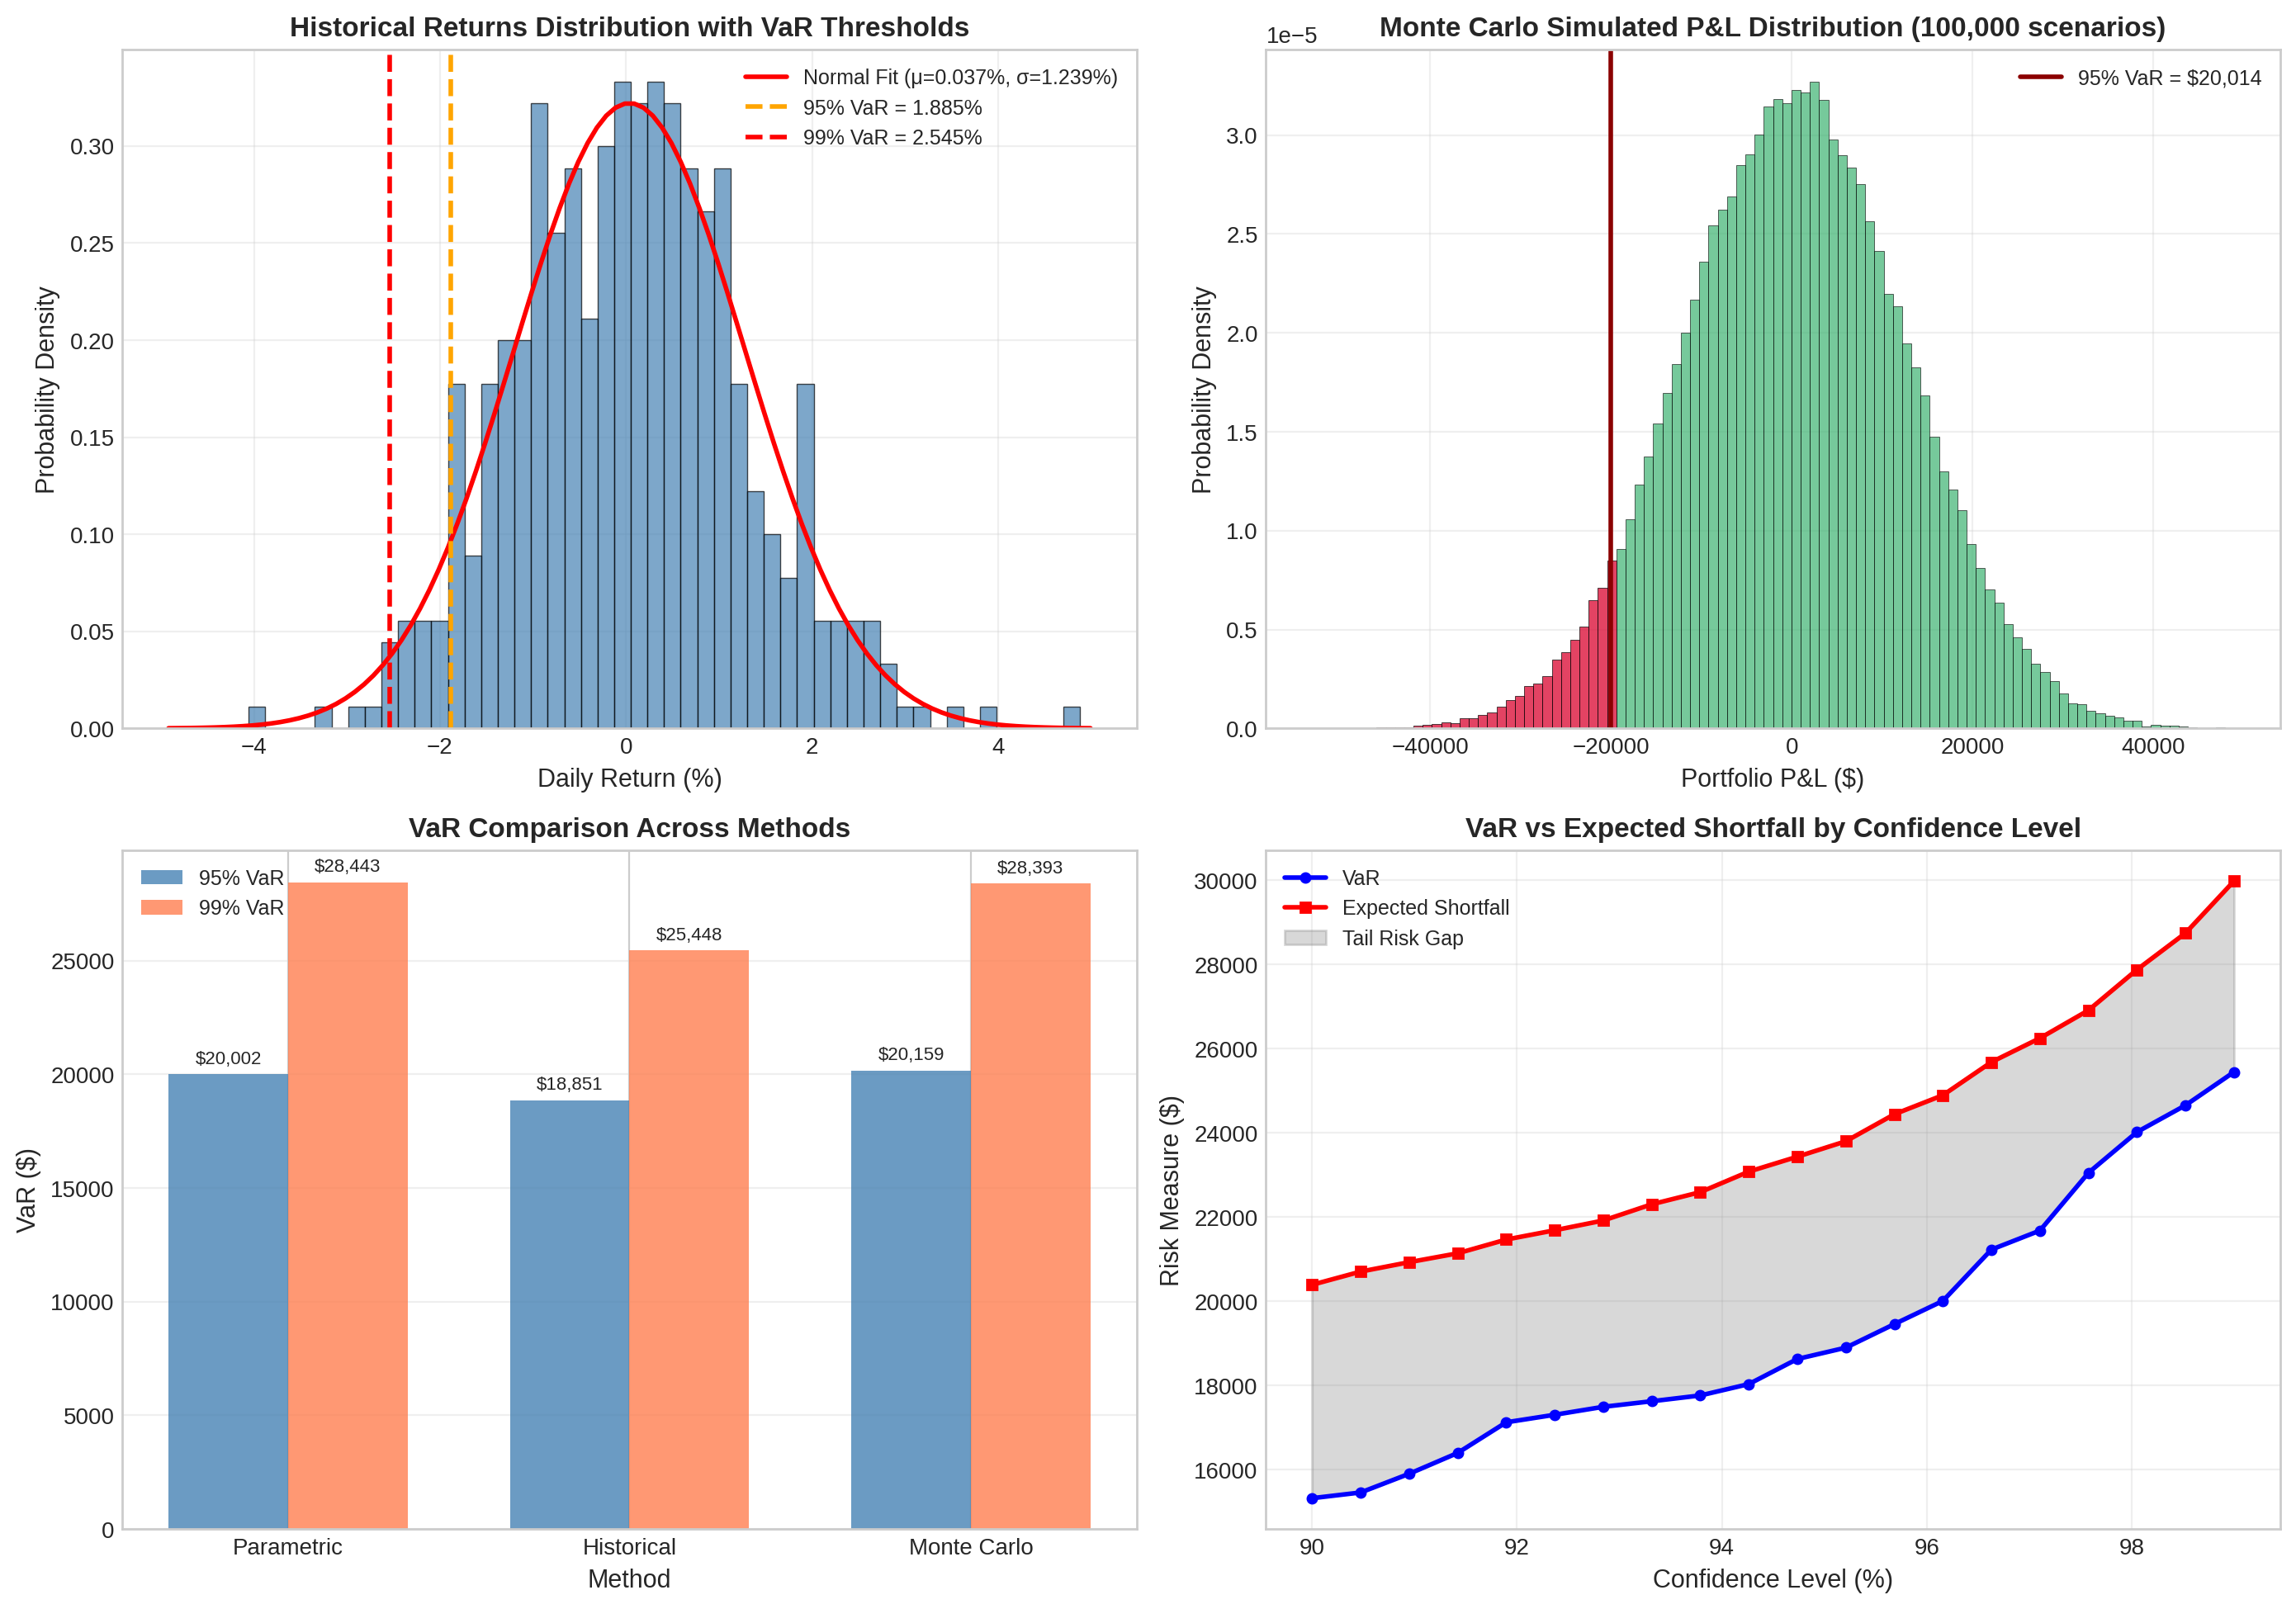


Visualization saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Historical Returns Distribution with VaR thresholds
ax1 = fig.add_subplot(2, 2, 1)

# Histogram of historical returns
n, bins, patches = ax1.hist(historical_returns * 100, bins=50, density=True, 
                            alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)

# Fit normal distribution
mu_hist = np.mean(historical_returns) * 100
sigma_hist = np.std(historical_returns) * 100
x_range = np.linspace(mu_hist - 4*sigma_hist, mu_hist + 4*sigma_hist, 100)
ax1.plot(x_range, norm.pdf(x_range, mu_hist, sigma_hist), 'r-', lw=2, 
         label=f'Normal Fit (μ={mu_hist:.3f}%, σ={sigma_hist:.3f}%)')

# Add VaR lines
var_95_pct, _ = historical_var(historical_returns, 0.95, portfolio_value)
var_99_pct, _ = historical_var(historical_returns, 0.99, portfolio_value)

ax1.axvline(-var_95_pct * 100, color='orange', linestyle='--', lw=2, 
            label=f'95% VaR = {var_95_pct*100:.3f}%')
ax1.axvline(-var_99_pct * 100, color='red', linestyle='--', lw=2, 
            label=f'99% VaR = {var_99_pct*100:.3f}%')

ax1.set_xlabel('Daily Return (%)', fontsize=11)
ax1.set_ylabel('Probability Density', fontsize=11)
ax1.set_title('Historical Returns Distribution with VaR Thresholds', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Monte Carlo Simulation Results
ax2 = fig.add_subplot(2, 2, 2)

# Run Monte Carlo for visualization
_, _, mc_returns = monte_carlo_var(historical_returns, 0.95, portfolio_value, n_simulations=100000)
mc_pnl = mc_returns * portfolio_value

n2, bins2, patches2 = ax2.hist(mc_pnl, bins=100, density=True, alpha=0.7, 
                               color='mediumseagreen', edgecolor='black', linewidth=0.3)

# Color the tail
var_95_dollar = np.percentile(mc_pnl, 5)
for patch, left_edge in zip(patches2, bins2[:-1]):
    if left_edge < var_95_dollar:
        patch.set_facecolor('crimson')
        patch.set_alpha(0.8)

ax2.axvline(var_95_dollar, color='darkred', linestyle='-', lw=2, 
            label=f'95% VaR = ${-var_95_dollar:,.0f}')

ax2.set_xlabel('Portfolio P&L ($)', fontsize=11)
ax2.set_ylabel('Probability Density', fontsize=11)
ax2.set_title('Monte Carlo Simulated P&L Distribution (100,000 scenarios)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: VaR Comparison across methods
ax3 = fig.add_subplot(2, 2, 3)

methods = ['Parametric', 'Historical', 'Monte Carlo']
var_95_values = [
    parametric_var(historical_returns, 0.95, portfolio_value)[1],
    historical_var(historical_returns, 0.95, portfolio_value)[1],
    monte_carlo_var(historical_returns, 0.95, portfolio_value, 100000)[1]
]
var_99_values = [
    parametric_var(historical_returns, 0.99, portfolio_value)[1],
    historical_var(historical_returns, 0.99, portfolio_value)[1],
    monte_carlo_var(historical_returns, 0.99, portfolio_value, 100000)[1]
]

x = np.arange(len(methods))
width = 0.35

bars1 = ax3.bar(x - width/2, var_95_values, width, label='95% VaR', color='steelblue', alpha=0.8)
bars2 = ax3.bar(x + width/2, var_99_values, width, label='99% VaR', color='coral', alpha=0.8)

ax3.set_xlabel('Method', fontsize=11)
ax3.set_ylabel('VaR ($)', fontsize=11)
ax3.set_title('VaR Comparison Across Methods', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(methods)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'${height:,.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'${height:,.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

# Plot 4: VaR vs Expected Shortfall
ax4 = fig.add_subplot(2, 2, 4)

conf_range = np.linspace(0.90, 0.99, 20)
var_values = []
es_values = []

for conf in conf_range:
    _, var_d = historical_var(historical_returns, conf, portfolio_value)
    _, es_d = expected_shortfall(historical_returns, conf, portfolio_value)
    var_values.append(var_d)
    es_values.append(es_d)

ax4.plot(conf_range * 100, var_values, 'b-', lw=2, marker='o', markersize=4, label='VaR')
ax4.plot(conf_range * 100, es_values, 'r-', lw=2, marker='s', markersize=4, label='Expected Shortfall')

ax4.fill_between(conf_range * 100, var_values, es_values, alpha=0.3, color='gray', 
                  label='Tail Risk Gap')

ax4.set_xlabel('Confidence Level (%)', fontsize=11)
ax4.set_ylabel('Risk Measure ($)', fontsize=11)
ax4.set_title('VaR vs Expected Shortfall by Confidence Level', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('value_at_risk_simulation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nVisualization saved to 'plot.png'")

## Interpretation and Conclusions

### Key Findings

1. **Method Comparison**: The three VaR methods (Parametric, Historical, Monte Carlo) produce similar results when the underlying distribution is approximately normal, as in our simulation.

2. **VaR Limitations**: VaR only tells us the threshold loss value, not the magnitude of losses beyond that threshold. This is why Expected Shortfall (ES) is increasingly preferred by regulators.

3. **Tail Risk**: The gap between VaR and ES illustrates the additional tail risk that VaR does not capture. At 99% confidence, the ES is significantly higher than VaR, indicating substantial potential losses in extreme scenarios.

### Practical Considerations

- **Parametric VaR** is computationally efficient but assumes normality, which may underestimate tail risk.
- **Historical VaR** makes no distributional assumptions but is limited by the available historical data.
- **Monte Carlo VaR** is flexible and can model complex instruments but requires careful specification of the underlying model.

### Regulatory Context

Post-2008 financial crisis, Basel III regulations moved towards Expected Shortfall as the primary market risk measure, recognizing its superior properties as a coherent risk measure that better captures tail risk.